---

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch import nn

from time import time
from tqdm import tqdm

from sklearn.metrics import roc_auc_score, average_precision_score,auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.utils import shuffle

import pandas as pd
import os
import sys

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

os.environ['CUDA_VISIBLE_DEVICES'] = '2'

device = torch.device('cuda' if (torch.cuda.is_available()) else 'cpu')
print('[INFO] -> Using Device: ', device)

[INFO] -> Using Device:  cpu


In [4]:
def _encode_text_dummy(df, name):
    
    names = []
    dummies = pd.get_dummies(df.loc[:,name])
    i = 0
    
    tmpL = []
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df.loc[:, dummy_name] = dummies[x]
        names.append(dummy_name)
        _x = [i, x]
        tmpL.append(_x)
        i += 1
    
    df.drop(name, axis=1, inplace=True)
    return names, tmpL


def _to_xy(df, target):
    """Converts a Pandas dataframe to the x,y inputs"""
    y = df[target]
    x = df.drop(columns=target)
    return x, y


def get_CreditCard(PATH, seed, mz = 1/4, my = 3/4, scale = True, show = False):
    
    df = pd.read_csv(PATH)
    
    labels = df['Class'].copy()
    #labels.replace({0: 1, 1: 0}, inplace = True)

    df['Class'] = labels

    normal = df[df['Class'] == 0] 
    abnormal = df[df['Class'] == 1]
    
    normal = shuffle(normal, random_state = seed)
    abnormal = shuffle(abnormal, random_state = seed)
    
    test_size_ab = int(len(abnormal)*(3/4))
    val_size_ab = int(len(abnormal)*(1/4))
    
    test_size_n = int(.15 * (len(normal) + len(abnormal)) - test_size_ab)
    val_size_n = int(.05 * (len(normal) + len(abnormal)) - val_size_ab)
    
    train_size = int(len(normal) - val_size_n - test_size_n)
    
    train_set = normal[:train_size]
    val_normal = normal[train_size: train_size+val_size_n]
    test_normal = normal[train_size+val_size_n: ]
    
    val_abnormal = abnormal[:val_size_ab]
    test_abnormal = abnormal[val_size_ab:val_size_ab+test_size_ab]
    
    val_set = pd.concat((val_normal, val_abnormal))
    test_set = pd.concat((test_normal, test_abnormal))
    
    x_train, y_train = _to_xy(train_set, target='Class')
    x_val, y_val = _to_xy(val_set, target='Class')
    x_test, y_test = _to_xy(test_set, target='Class')
    
    if show:
        print('{} normal records, {} anormal records'.format(len(normal), len(abnormal)))
        print('-' * 89)
        print(f'There are {len(x_train)} records in training set')
        print(f'Training set is composed by {len(x_train[y_train == 0])} normal records and {len(x_train[y_train == 1])} abnormal records')
        print('-' * 89)
        print(f'There are {len(x_val)} records in validation set')
        print(f'Validation set is composed by {len(x_val[y_val == 0])} normal records and {len(x_val[y_val == 1])} abnormal records')
        print('-' * 89)
        print(f'There are {len(x_test)} records in test set')
        print(f'Test set is composed by {len(x_test[y_test == 0])} normal records and {len(x_test[y_test == 1])} abnormal records')
    
    x_train = x_train.to_numpy()
    x_val = x_val.to_numpy()
    x_test = x_test.to_numpy()
    
    if scale:
        scaler = MinMaxScaler()
        scaler.fit(x_train)
        x_train = scaler.transform(x_train)
        x_val = scaler.transform(x_val)
        x_test = scaler.transform(x_test)
        
        
    dataset = {}
    dataset['x_train'] = x_train.astype(np.float32)
    dataset['y_train'] = y_train.astype(np.float32)
    
    dataset['x_val'] = x_val.astype(np.float32)
    dataset['y_val'] = y_val.astype(np.float32)
    
    dataset['x_test'] = x_test.astype(np.float32)
    dataset['y_test'] = y_test.astype(np.float32)
    
    dataset['scaler'] = scaler
    
    return dataset

In [5]:
batch_size = 1024

WORK_SPACE = '../Dataset'

SPACE_MODELS = './models'
SPACE_AUC = './auc'
SPACE_AUPRC = './auprc'

for n in (SPACE_MODELS, SPACE_AUC, SPACE_AUPRC):
    if not os.path.exists(n):
        os.mkdir(n)
        
DATASET = 'CreditCard'
FILE = 'creditcard.csv'

PATH = os.path.join(WORK_SPACE, DATASET, FILE)

In [6]:
dataset = get_CreditCard(PATH, seed, show=True)

284315 normal records, 492 anormal records
-----------------------------------------------------------------------------------------
There are 227846 records in training set
Training set is composed by 227846 normal records and 0 abnormal records
-----------------------------------------------------------------------------------------
There are 14240 records in validation set
Validation set is composed by 14117 normal records and 123 abnormal records
-----------------------------------------------------------------------------------------
There are 42721 records in test set
Test set is composed by 42352 normal records and 369 abnormal records


## Model

In [7]:
def meanAUC_PRAUC(auc_list, pr_list, name, SPACE_AUC, SPACE_AUPRC):
    print('AUC:')
    print(auc_list)
    print('**************')
    print('PR AUC:')
    print(pr_list)
    print('**************')
    
    
    AUC_Frame = pd.DataFrame(auc_list, columns = [name])
    PR_AUC_Frame = pd.DataFrame(pr_list, columns = [name])
    
    AU_NAME = f'{name}.csv'
    
    AUC_Frame.to_csv(os.path.join(SPACE_AUC, AU_NAME), index=False)
    PR_AUC_Frame.to_csv(os.path.join(SPACE_AUPRC, AU_NAME), index=False)
    
    AUC_Frame = list(AUC_Frame[name])

    N = len(AUC_Frame)
    mean_auc = np.mean(AUC_Frame)
    std_auc = np.std(AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')
    print('**************')
    
    PR_AUC_Frame = list(PR_AUC_Frame[name])

    N = len(PR_AUC_Frame)
    mean_auc = np.mean(PR_AUC_Frame)
    std_auc = np.std(PR_AUC_Frame)
    std_error = std_auc / (np.sqrt(N))

    ci = 1.96 * std_error
    lower_bound = mean_auc - ci
    upper_bound = mean_auc + ci
    
    print('PR AUC')
    print(f'{mean_auc:.2f} +/- {ci:.2f}')
    print(f'95% confidence level, average auc would be between {lower_bound:.2f} and {upper_bound:.2f}')

class Autoencoder(nn.Module):
    def __init__(self, nf_in = 121, nf_out = 32, z_dim = 16):
        super(Autoencoder, self).__init__()

        self.nf_in = nf_in
        self.nf_out = nf_out
        self.z_dim = z_dim

        self.encoder = nn.Sequential(
            nn.Linear(self.nf_in, self.nf_out * 2), # 121@64
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.LeakyReLU(0.2),
            
            nn.Linear(self.nf_out * 2, self.nf_out), # 64@32
            nn.BatchNorm1d(self.nf_out, track_running_stats = False),
            nn.LeakyReLU(0.2),
            
            nn.Linear(self.nf_out, self.z_dim), # 32@16
            nn.BatchNorm1d(self.z_dim, track_running_stats = False),
            nn.LeakyReLU(0.2)
        
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.z_dim, self.nf_out), # 16@32
            nn.BatchNorm1d(self.nf_out, track_running_stats = False),
            nn.ReLU(),
            
            nn.Linear(self.nf_out, self.nf_out * 2), # 32@64
            nn.BatchNorm1d(self.nf_out * 2, track_running_stats = False),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            
            nn.Linear(self.nf_out * 2, self.nf_in) # 64@121
        )
        
        self.sigmoid = nn.Sigmoid()

        self.init_weights()  
        
    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        enc = self.encoder(x)
        dec = self.decoder(enc)
        
        rec = self.sigmoid(dec)
        return rec
    
    
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.mse = nn.MSELoss(reduction = 'mean')

    def forward(self, true_data, rec_data):
        rec = self.mse(true_data, rec_data)
        return rec
    

class BaselineTrainer(nn.Module):
    def __init__(self, device, nc):
        super(BaselineTrainer, self).__init__()
        self.device = device
        
        self.nc = nc

        self.AE = Autoencoder(nf_in = self.nc).to(self.device)

        self.ae_optimizer = torch.optim.Adam(self.AE.parameters(), lr=1e-4)
        self.loss = Loss()
            
            
    def evaluation(self, test_loader):
        self.AE.eval()
        aeL = []
    
        for batch, label in test_loader:
            batch = batch.to(self.device)
            label = label.to(self.device)
            
            with torch.no_grad():
                rec_data = self.AE(batch)   
                ae_loss_batch = self.loss(batch, rec_data)
                
            aeL.append(ae_loss_batch.item())
            
        return np.mean(aeL)
    
        
    def AE_step(self, true_data):
        self.AE.zero_grad()
        
        rec_data = self.AE(true_data)    
        
        ae_loss_batch = self.loss(true_data, rec_data)
        ae_loss_batch.backward()

        self.ae_optimizer.step()

        return ae_loss_batch
    
    def predict(self, test_loader):
        self.AE.eval()
        
        i = 0

        for batch, label in test_loader:
            batch = batch.to(self.device)
            label = label.to(self.device)
            
            with torch.no_grad():
                rec_data = self.AE(batch)
             
            err = []
            for b, r in zip(batch, rec_data):
                mse = ((b-r)**2).mean()
                p = 1-torch.exp(-mse)
                err.append(p.item())
                
            if i == 0:
                y_true = label.cpu()
                pred = torch.tensor(err)
            else:
                y_true = torch.cat((y_true, label.cpu()))
                pred = torch.cat((pred, torch.tensor(err)))

            i += 1
                
        return y_true, pred
    
    def plot_pr_curve(self, precision, recall):
        plt.figure()
        plt.plot(recall, precision, marker='.')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
    
    def pr_auc(self, y_test, y_pred):
        precision, recall, _ = precision_recall_curve(y_test, y_pred)
        auc_score = auc(recall, precision)
        print(f'PR AUC: {auc_score:.2f}')
        self.plot_pr_curve(precision, recall)
        return auc_score
    
    def plotLoss(self, ae_losses, ae_losses_val):
        num_epochs = len(ae_losses)


        plt.figure()
        plt.xlim(0, num_epochs + 1)
        plt.plot(range(1, num_epochs + 1), ae_losses[:num_epochs], label='ae loss')
        plt.plot(range(1, num_epochs + 1), ae_losses_val[:num_epochs], '--', label='ae loss val')

        plt.legend()
        plt.show()  

        
    def train(self, data_loader, test_loader, batch_size = 32, num_epochs = 10, step = 10, lowerbnd=5e-15):
        
        ae_losses = np.zeros(num_epochs)
        ae_losses_val = np.zeros(num_epochs)
        
        
        total_steps = (len(data_loader.dataset) // batch_size) #*num_epochs
        print("[INFO] Starting training phase...")
        start = time()
        
        try:
            
            for epoch in range(num_epochs):
                self.AE.train()
                
                i = 0
                for batch in data_loader:
                    batch = batch.to(self.device)
                    
                    ae_loss = self.AE_step(batch)
                    ae_losses[epoch] = ae_losses[epoch]*(i/(i+1.)) + ae_loss.item()*(1./(i+1.))
                    
                    
                    if (i+1) % step == 0:
                        sys.stdout.write("\r" + 'Epoch [{:>3}/{}] | Step [{:>3}/{}]| ae_loss: {:.4f} '
                              .format(epoch+1, num_epochs, i+1, total_steps, ae_loss.item()))
                        sys.stdout.flush()
                        
                    i += 1
                
                aeLossVal = self.evaluation(test_loader)
                ae_losses_val[epoch] = aeLossVal
                
        
        except KeyboardInterrupt:
            print('-' * 89)
            print('[INFO] Exiting from training early')
        print(f'\n[INFO] Training phase... Elapsed time: {(time() - start):.0f} seconds\n')
        self.plotLoss(ae_losses, ae_losses_val)
        return ae_losses[:epoch], ae_losses_val[:epoch]

#### Mean AUC and standard deviation after seven runs

Iteration: 1
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 132 seconds



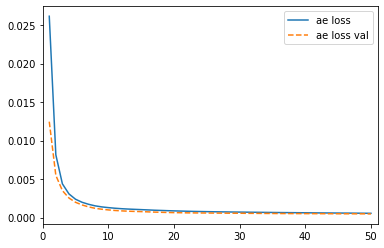

PR AUC: 0.75


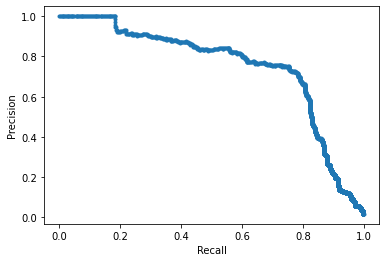

AUC: 0.99
Iteration: 2
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 133 seconds



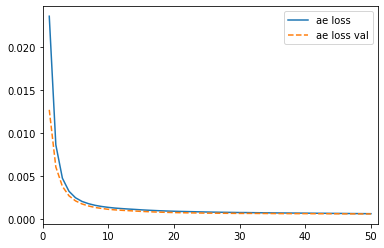

PR AUC: 0.74


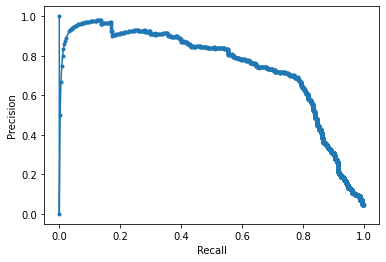

AUC: 0.99
Iteration: 3
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 130 seconds



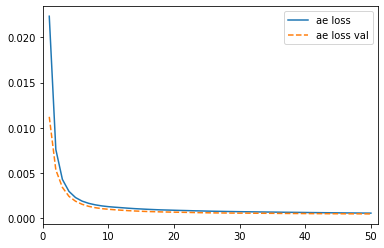

PR AUC: 0.78


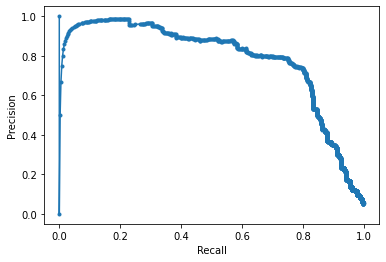

AUC: 0.99
Iteration: 4
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0007 
[INFO] Training phase... Elapsed time: 129 seconds



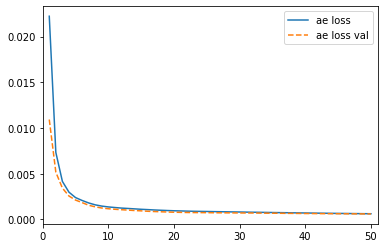

PR AUC: 0.74


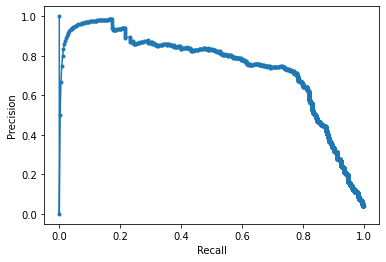

AUC: 0.99
Iteration: 5
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 127 seconds



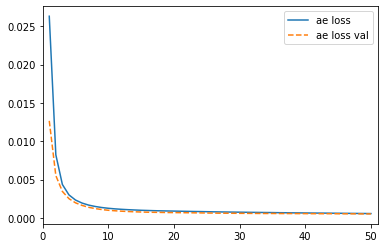

PR AUC: 0.77


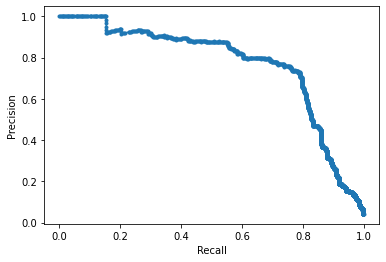

AUC: 0.99
Iteration: 6
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 126 seconds



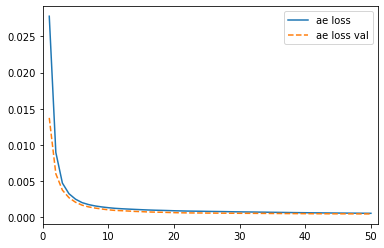

PR AUC: 0.78


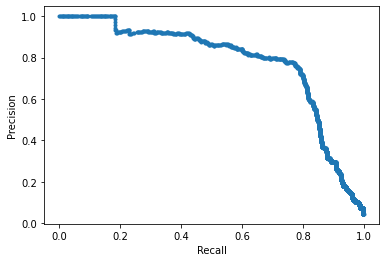

AUC: 0.99
Iteration: 7
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 129 seconds



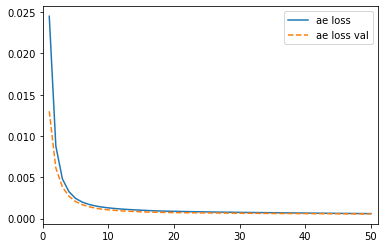

PR AUC: 0.72


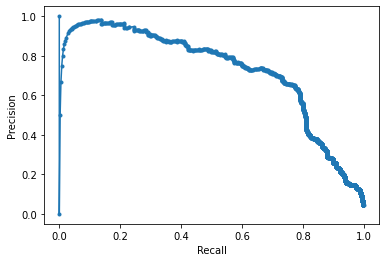

AUC: 0.99
Iteration: 8
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0005 
[INFO] Training phase... Elapsed time: 127 seconds



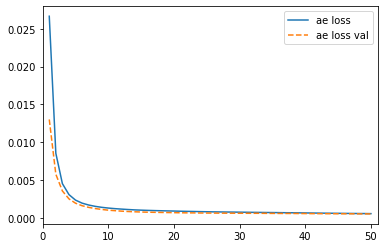

PR AUC: 0.79


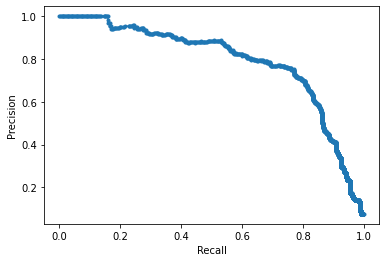

AUC: 0.99
Iteration: 9
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 133 seconds



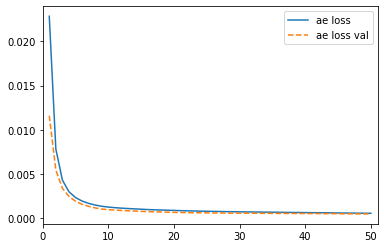

PR AUC: 0.75


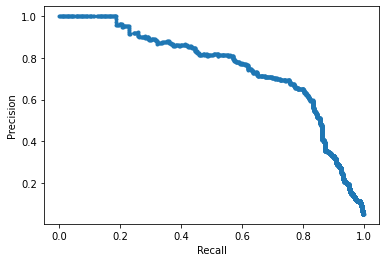

AUC: 0.99
Iteration: 10
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0005 
[INFO] Training phase... Elapsed time: 130 seconds



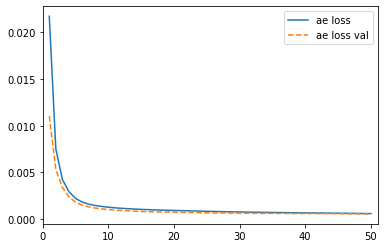

PR AUC: 0.76


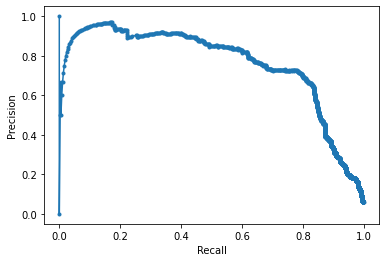

AUC: 0.99
Iteration: 11
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 132 seconds



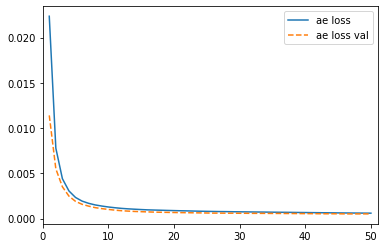

PR AUC: 0.75


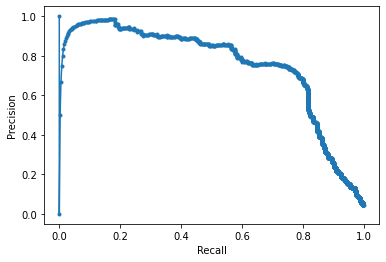

AUC: 0.99
Iteration: 12
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 131 seconds



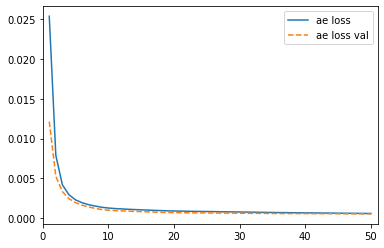

PR AUC: 0.74


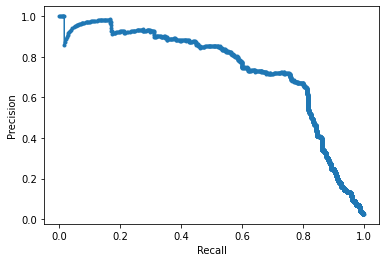

AUC: 0.99
Iteration: 13
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 131 seconds



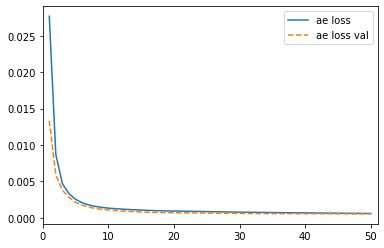

PR AUC: 0.79


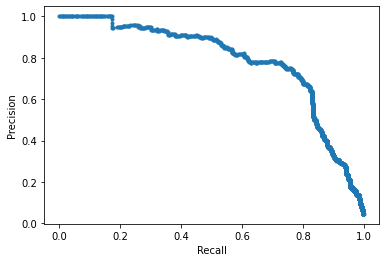

AUC: 0.99
Iteration: 14
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 129 seconds



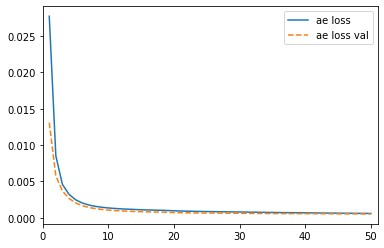

PR AUC: 0.76


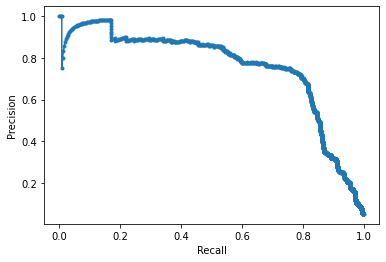

AUC: 0.99
Iteration: 15
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 127 seconds



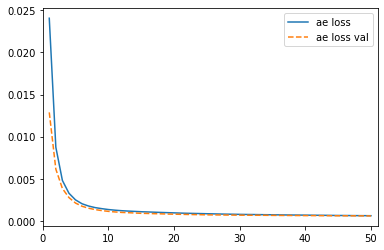

PR AUC: 0.75


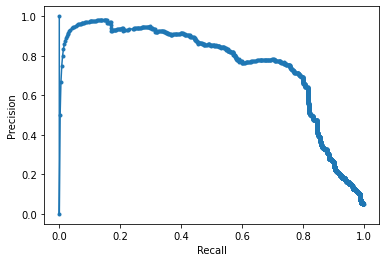

AUC: 0.99
Iteration: 16
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 129 seconds



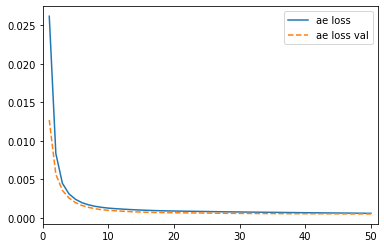

PR AUC: 0.80


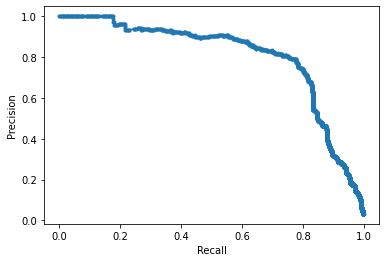

AUC: 0.99
Iteration: 17
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 128 seconds



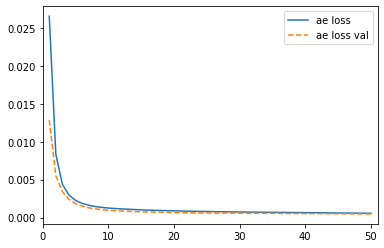

PR AUC: 0.79


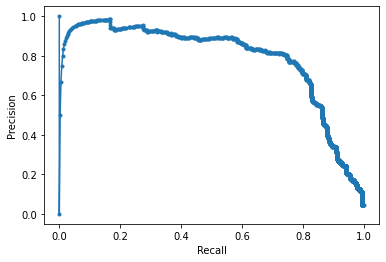

AUC: 0.99
Iteration: 18
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 127 seconds



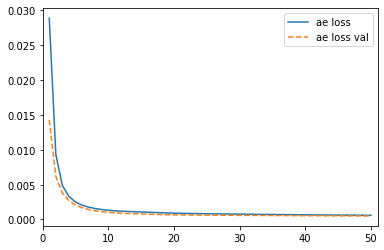

PR AUC: 0.79


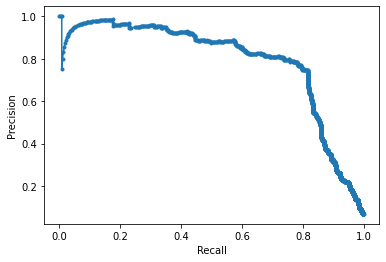

AUC: 0.99
Iteration: 19
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0006 
[INFO] Training phase... Elapsed time: 133 seconds



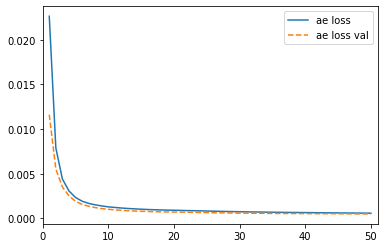

PR AUC: 0.74


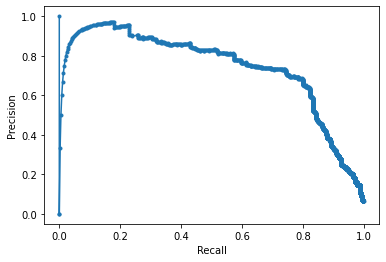

AUC: 0.99
Iteration: 20
[INFO] Starting training phase...
Epoch [ 50/50] | Step [220/222]| ae_loss: 0.0005 
[INFO] Training phase... Elapsed time: 129 seconds



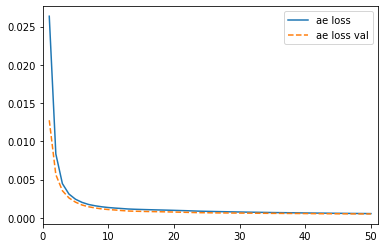

PR AUC: 0.80


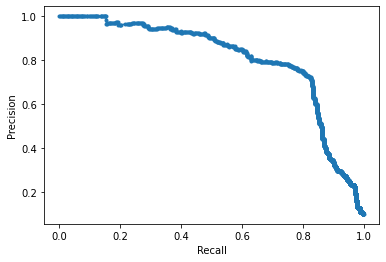

AUC: 1.00


In [8]:
n_runs = 20
auc_list = []
num_epochs = 50
seed = 42
pr_list = []

for i in range(n_runs):
    print(f'Iteration: {i+1}')
    dataset = get_CreditCard(PATH, seed*(i+1), show=False)
    
    train_loader = DataLoader(dataset=torch.FloatTensor(dataset['x_train']), 
                          batch_size = batch_size, shuffle=True, drop_last = True)

    val_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_val']), 
                                              torch.tensor(dataset['y_val'].to_numpy()))
    val_loader = DataLoader(dataset=val_dataset, batch_size = batch_size, shuffle=False)

    test_dataset = torch.utils.data.TensorDataset(torch.tensor(dataset['x_test']), 
                                              torch.tensor(dataset['y_test'].to_numpy()))
    test_loader = DataLoader(dataset=test_dataset, batch_size = batch_size, shuffle=False)
    
    trainer = BaselineTrainer(device, dataset['x_train'].shape[1])
    
    ae_loss, ae_loss_val = trainer.train(train_loader, val_loader, batch_size = batch_size, num_epochs = num_epochs)
    
    # Save Models
    AE_MODEL = f'BASELINE_{DATASET}_{i}.ckpt'
    torch.save(trainer.AE.state_dict(), os.path.join(SPACE_MODELS, AE_MODEL))
    
    y_true, yP = trainer.predict(test_loader)
    _auc = roc_auc_score(y_true, yP)
    pr = trainer.pr_auc(y_true, yP)
    print(f'AUC: {_auc:.2f}')
    
    auc_list.append(_auc)
    pr_list.append(pr)

In [9]:
meanAUC_PRAUC(auc_list, pr_list, 'Baseline_CreditCard', SPACE_AUC, SPACE_AUPRC)

AUC:
[0.9881885191396305, 0.9922779392839263, 0.9936399915330849, 0.9929291469199164, 0.9928121445456992, 0.9930691210482184, 0.9929127979417308, 0.9949790400340723, 0.9937042676528012, 0.99465785140001, 0.9922594467019471, 0.9896950246891967, 0.9944037543652731, 0.993711274357738, 0.9926667954108706, 0.9941713173270758, 0.9945172693840652, 0.9944391718189943, 0.9946608908382246, 0.9954884818729185]
**************
PR AUC:
[0.750614607266057, 0.742305560586382, 0.7809617052693334, 0.7394053105942686, 0.767591878652281, 0.7811132295183577, 0.7241100053305418, 0.7913476311734086, 0.7519240894986808, 0.7580643375971008, 0.7491802655226758, 0.742191072199322, 0.7854065615223182, 0.7568008066487968, 0.7532098984108728, 0.8046990648343413, 0.7852319733404153, 0.7911165226271436, 0.739112448969694, 0.8041829860506282]
**************
AUC
0.99 +/- 0.00
95% confidence level, average auc would be between 0.99 and 0.99
**************
PR AUC
0.76 +/- 0.01
95% confidence level, average auc would be b

---